In [5]:
#import
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt


In [6]:
#最大行列数の調整
pd.get_option('display.max_columns'),pd.get_option('display.max_rows')
pd.set_option('display.max_columns',100)

In [7]:
#input the dataset
train_pitch = pd.read_csv('train_pitch.csv')
test_pitch = pd.read_csv('test_pitch.csv')

### pitch側の前処理とエンコーディング


In [8]:
#label Encoding
#表裏
tb_dic = {'表' : 0, '裏' : 1}
train_pitch['表裏'] = train_pitch['表裏'].map(tb_dic)
test_pitch['表裏'] = test_pitch['表裏'].map(tb_dic)

#右か左か
hands_dic = {'右' : 0, '左' : 1}
train_pitch['打者打席左右'] = train_pitch['打者打席左右'].map(hands_dic)
train_pitch['投手投球左右'] = train_pitch['投手投球左右'].map(hands_dic)
test_pitch['打者打席左右'] = test_pitch['打者打席左右'].map(hands_dic)
test_pitch['投手投球左右'] = test_pitch['投手投球左右'].map(hands_dic)

#先発or救援
roll_dic = {'先発':0, '救援':1}
train_pitch['投手役割'] = train_pitch['投手役割'].map(roll_dic)
test_pitch['投手役割'] = test_pitch['投手役割'].map(roll_dic)

#セ公式、パ公式、セパ交流戦
game_dic = {'セ・リーグ公式戦' :1, 'パ・リーグ公式戦':2, 'セ・パ交流戦':0}
train_pitch['試合種別詳細'] = train_pitch['試合種別詳細'].map(game_dic)
test_pitch['試合種別詳細'] = test_pitch['試合種別詳細'].map(game_dic)

#日付をハイフン無しで
train_pitch['日付'] = train_pitch['日付'].str.replace('-','').astype(int)
test_pitch['日付'] = test_pitch['日付'].str.replace('-','').astype(int)

In [9]:
#塁にいるかいないかにしたい。
def func(x):
    if x == x:
        return 1
    return 0
train_pitch.loc[:,['一塁走者ID','二塁走者ID','三塁走者ID']] = train_pitch.loc[:,['一塁走者ID','二塁走者ID','三塁走者ID']].applymap(func)
test_pitch.loc[:,['一塁走者ID','二塁走者ID','三塁走者ID']] = test_pitch.loc[:,['一塁走者ID','二塁走者ID','三塁走者ID']].applymap(func)

#day or night
def time(x):
    if int(x[0:2]) > 18:
        return 0#day
    else:
        return 1#night
train_pitch['時刻'] = train_pitch['時刻'].map(time)
test_pitch['時刻'] = test_pitch['時刻'].map(time)

#プレイ前走者状況→一旦、居る塁にする。['___', '_2_', '1__', '12_', '_23', '1_3', '__3', '123']
def runner(x):
    if x == '___':
        return 0
    elif x == '1__':
        return 1
    elif x == '_2_':
        return 2
    elif x == '__3':
        return 3
    elif x == '12_':
        return 12
    elif x == '1_3':
        return 13
    elif x == '_23':
        return 23
    else:
        return 123
train_pitch['プレイ前走者状況'] = train_pitch['プレイ前走者状況'].map(runner)
test_pitch['プレイ前走者状況'] = test_pitch['プレイ前走者状況'].map(runner)


### player側の前処理とラベルエンコーディング

In [10]:
#読み込み
train_player = pd.read_csv('train_player.csv')
test_player = pd.read_csv('test_player.csv')

In [11]:
#dicでイジれるやつ
hands_dic['両'] = 2
train_player['投'] = train_player['投'].map(hands_dic)
train_player['打'] = train_player['打'].map(hands_dic)
test_player['投'] = test_player['投'].map(hands_dic)
test_player['打'] = test_player['打'].map(hands_dic)

In [12]:
#大学に行ったか行っていないか
def univ(x):
    if x == '不明':
        return 0
    else:
        return 1
train_player['出身大学名'] = train_player['出身大学名'].map(univ)
test_player['出身大学名'] = test_player['出身大学名'].map(univ)

#出身国→日本or海外
def country(x):
    if x == '日本':
        return 1
    else:
        return 0
train_player['出身国'] = train_player['出身国'].map(country)
test_player['出身国'] = test_player['出身国'].map(country)    

In [13]:
#社会人経験
train_player['社会人'] = train_player['社会人'].map(func)
test_player['社会人'] = test_player['社会人'].map(func)    

In [14]:
#ドラフト種別nan, '高校生', '大学生・社会人', '育成選手'
def draft(x):
    if x == '高校生':
        return 1
    elif x =='大学生・社会人':
        return 2
    elif x =='育成選手':
        return 3
    else:
        return 0
train_player['ドラフト種別'] = train_player['ドラフト種別'].map(draft)
test_player['ドラフト種別'] = test_player['ドラフト種別'].map(draft)

In [15]:
#生年月日をyyyymmdd形式に
train_player['生年月日'] = pd.DataFrame(list(map(lambda x : x.replace('/','') if len(x) ==10 else x.replace('/','0') if len(x) == 8 else x.replace('/','0',1).replace('/','') ,train_player['生年月日'])))
test_player['生年月日'] = pd.DataFrame(list(map(lambda x : x.replace('/','') if len(x) ==10 else x.replace('/','0') if len(x) == 8 else x.replace('/','0',1).replace('/','') ,test_player['生年月日'])))

### 両方の値を使っての処理

とりあえず今は、ラベル付けして、突っ込んでるだけ
今からやることは以下.

1. 選手情報をまとめたｄｆをつくる。
2. そのｄｆを利用してpitchの方にある選手IDと比較する。
3. 同じIDの選手のデータをpatchのｄｆに入れる。

なお今回は登録IDに2018と２０１９の２年度分あるので、重複している選手もいる。
年度と紐付けて選手IDは割り振る必要がありそう。

>これは前日までに投げてる球種を集めてみれば使えそう？それはオッケイだと思う。→リークに当たるの？？

->ボール数が３のときはストレート多そう
>def balls(df)->意味無し。数値の情報は判断してそう。


In [16]:
#元のやつにIDベースでくっつけるため年度とIDを足す。
train_pitch['選手ID'] = train_pitch['年度']+train_pitch['投手ID']
train_player['選手ID'] = train_player['年度']+train_player['選手ID']

#元のやつにIDベースでくっつけるため年度とIDを足す。
def merge_word(x,y):
    return str(x)+str(y)
test_pitch['選手ID'] = pd.DataFrame(list(map(merge_word, test_pitch['年度'],test_pitch['投手ID'])))
test_player['選手ID']= pd.DataFrame(list(map(merge_word, test_player['年度'], test_player['選手ID'])))

In [17]:
#merge
train = train_pitch.merge(train_player.drop(['年度'],axis=1), on='選手ID', how='left')
test = test_pitch.merge(test_player.drop(['年度'],axis=1), on='選手ID', how='left')

In [18]:
#生年月日,日付->当時の年齢
#yyyymmdd入力
def age_culc(d1,d2):
    return (d1-d2)//10000

train['age'] = pd.DataFrame(age_culc(train['日付'].astype(int),train['生年月日'].astype(int)))
test['age'] = pd.DataFrame(age_culc(test['日付'].astype(int),test['生年月日'].astype(int)))

## 特徴量

作りたいもの
    1. 投手の各対戦チームに対する球種割合(千賀は日ハム相手のときは6割ストレート,２割フォークとか)
    2.　捕手の各対戦チームに対する球種割合(甲斐が捕手のときは西武相手で6割ストレートとか)

とりあえず、準備として投手ID、投手名、球種、日付、時刻、球場、ホームチームID、アウェイチームID、イニングのｄｆを作る。

    3. まずは投手ごとに投げる球種割合を出す。->精度上がった⭕
    4. 加えて捕手の分も作る。->精度下がった❌
    
ストレートか否かを判定するのが結構大事そう。→結局ストレートが多い。→不均衡データ

    ５．カリブレーション
    6.アップ、ダウンサンプリング->意味無し
   
    
１を出したんだけど精度が大幅に下る
    
    7. NaNがめちゃくちゃ多いので、それを埋める。モデルに学習させて、その予測値で埋めようと思う。→結局fastが多め。
    　8. 確率を補正する。(ストレートの割合が多いので、ストレートの確率が大きくなってしまう)→これが６なんだけど、あんまり意味ないかも。データ数減らすのは悪手
     

In [19]:
# 投手/year.ver
#NaN　or not
def nan(x):
    if x == x:
        return True
    return False
# ロングフォーマットを得る。
tr = train.copy()
def get_longf(df):
    df['番号'] =  range(len(df))
    pitcher_info_l = df.loc[:,['日付','投手ID','球種','番号']]
    pitcher_info_l.index = pitcher_info_l['日付']
    pitcher_info_l = pitcher_info_l.drop(['日付'],axis=1)
    return pitcher_info_l

#ロングフォーマットをワイドフォーマットにして投球割合を得る。->for文を使わずに書きたいなぁ。
def get_pitching_rate(lf):
    pitcher_info_w = lf.pivot_table(index ='日付' ,columns=('投手ID','番号'), values = '球種').dropna(how='all')
    pitch_rate = []
    for i in lf['投手ID'].unique():
        df = pitcher_info_w[i]
        df = df.applymap(nan)#数値(True) or NAN(False)
        x = df.values.sum()#Trueが全投球数なので集計
        rate=[]
        rate.append(i)
        for j in range(8):
            df2 = pitcher_info_w[i] == j#0~7までの球種それぞれをTrueに
            y = df2.values.sum()#Trueがそれぞれの球種を投げた回数集計
            rate.append(y/x)#全投球数で割ったものを入れる。
        pitch_rate.append(rate)
    return pitch_rate
pitching_rate = get_pitching_rate(get_longf(tr))

In [20]:
#to  pd.DAtaFrame
columns = ['投手ID','fast_y','curve_y','slider_y','shoot_y','fork_y','change_y','sinker_y','cut_y']
pitching_rate_yaer = pd.DataFrame(pitching_rate,columns=columns)

In [21]:
#投球区域の方
# ロングフォーマットを得る。
def get_longf(df):
    df['番号'] =  range(len(df))
    pitcher_info_l = df.loc[:,['日付','投手ID','投球位置区域','番号']]
    pitcher_info_l.index = pitcher_info_l['日付']
    pitcher_info_l = pitcher_info_l.drop(['日付'],axis=1)
    return pitcher_info_l

#ロングフォーマットをワイドフォーマットにして投球割合を得る。->for文を使わずに書きたいなぁ。
def get_pitching_place(lf):
    pitcher_info_w = lf.pivot_table(index ='日付' ,columns=('投手ID','番号'), values = '投球位置区域').dropna(how='all')
    pitch_place = []
    for i in lf['投手ID'].unique():
        df = pitcher_info_w[i]
        df = df.applymap(nan)#数値(True) or NAN(False)
        x = df.values.sum()#Trueが全投球数なので集計
        place=[]
        place.append(i)
        for j in range(13):
            df2 = pitcher_info_w[i] == j#0~7までの球種それぞれをTrueに
            y = df2.values.sum()#Trueがそれぞれの球種を投げた回数集計
            place.append(y/x)#全投球数で割ったものを入れる。
        pitch_place.append(place)
    return pitch_place
pitching_place = get_pitching_place(get_longf(tr))

In [22]:
# to pd.DataFrame
columns = ['投手ID',0,1,2,3,4,5,6,7,8,9,10,11,12]
pitching_place_yaer = pd.DataFrame(pitching_place,columns=columns)

In [23]:
pitching_place_yaer

,投手ID,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1500001,0.054502,0.052471,0.040623,0.053825,0.066689,0.060257,0.058226,0.084631,0.066351,0.115775,0.095464,0.075491,0.175694
1,1000138,0.043148,0.063124,0.059529,0.059928,0.050739,0.052737,0.047942,0.053935,0.039153,0.079505,0.128646,0.184978,0.136636
2,1600019,0.056732,0.086989,0.083207,0.040091,0.049924,0.043873,0.045386,0.047655,0.041604,0.108169,0.081694,0.232224,0.082451
3,1200005,0.076781,0.053654,0.037928,0.062905,0.057354,0.048104,0.055504,0.063830,0.042553,0.165587,0.109158,0.074931,0.151711
4,1500082,0.052408,0.080737,0.053824,0.032578,0.066572,0.038244,0.028329,0.043909,0.048159,0.135977,0.052408,0.147309,0.219547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,1500130,0.044118,0.044118,0.044118,0.029412,0.058824,0.088235,0.058824,0.088235,0.029412,0.088235,0.088235,0.088235,0.250000
322,1500065,0.096386,0.060241,0.024096,0.048193,0.012048,0.084337,0.012048,0.036145,0.060241,0.144578,0.096386,0.192771,0.132530
323,1500088,0.000000,0.111111,0.111111,0.111111,0.000000,0.111111,0.000000,0.000000,0.000000,0.111111,0.111111,0.222222,0.111111
324,1600115,0.037736,0.075472,0.018868,0.018868,0.075472,0.000000,0.037736,0.113208,0.000000,0.264151,0.113208,0.056604,0.188679


In [24]:
# #投手/相手チーム.ver
# # ロングフォーマットを得る。
# tr = train.copy()
# def get_lf(df):
#     df['番号'] =  range(len(df))
#     pitcher_info_l = df.loc[:,['日付','投手ID','球種','番号','打者チームID']]
#     pitcher_info_l.index = pitcher_info_l['日付']
#     pitcher_info_l = pitcher_info_l.drop(['日付'],axis=1)
#     return pitcher_info_l

# #ある選手がある対戦チーム相手に投げた球種割合
# def get_pitching_rate_team(df):
#     pitcher_info = get_lf(tr).pivot_table(index ='日付' ,columns=('投手ID','打者チームID','番号'), values = '球種')
#     pitching_rate_team = []#[[pitcherID,teamID,fast,curev...],[],[]...]
#     for i in get_lf(tr)['投手ID'].unique():
#         for j in get_lf(tr)['打者チームID'].unique():
#             if j in pitcher_info[i]:
#                 x = pitcher_info[(i,j)].applymap(nan).values.sum()#iの選手がjのチームに対して、何球投げたかのsum
#                 rate_team = []#[pitcherID,teamID,fast,curev...]
#                 rate_team.append(i)
#                 rate_team.append(j)
#                 for k in range(8):
#                     df = pitcher_info[(i,j)] == k
#                     y = df.values.sum()#iの選手がjのチームに対して,kのたまを何球投げたかのsum
#                     rate_team.append(y/x)
#                 pitching_rate_team.append(rate_team)
#             continue
#     return pitching_rate_team

# pitching_rate_team = get_pitching_rate_team(get_lf(tr))

In [25]:
# #to pd.Dataframe
# columns = ['投手ID','対戦チーム','fast_t','curve_t','slider_t','shoot_t','fork_t','change_t','sinker_t','cut_t']
# pitching_rate_team = pd.DataFrame(pitching_rate_team,columns=columns)


In [26]:
#pitching_rate_team.head()

In [27]:
#投手と打者の利き手のEXOR
def EXOR(x,y):
    return x^y

train['投打EXOR'] = pd.DataFrame(list(map(EXOR,train['投手投球左右'],train['打者打席左右'])))
test['投打EXOR'] = pd.DataFrame(list(map(EXOR,test['投手投球左右'],test['打者打席左右'])))

In [28]:
#特徴量をtrainに引っ付ける。
#退避
train_val = train.copy()
test_val = test.copy()

#pitching_rate_yaer
train = train.merge(pitching_rate_yaer, on='投手ID', how='left')
test = test.merge(pitching_rate_yaer, on='投手ID', how='left')

#pitching_rate_team
#def merge_word(x,y):
    #return str(x)+str(y)
# pitching_rate_team['試合投手ID'] = pd.DataFrame(list(map(merge_word, pitching_rate_team['投手ID'],pitching_rate_team['対戦チーム'])))
# pitching_rate_team = pitching_rate_team.drop(['投手ID'],axis=1)

# train['試合投手ID'] = pd.DataFrame(list(map(merge_word, train['投手ID'],train['打者チームID'])))
# test['試合投手ID'] = pd.DataFrame(list(map(merge_word, test['投手ID'],test['打者チームID'])))

# train = train.merge(pitching_rate_team, on='試合投手ID', how='left')
# test = test.merge(pitching_rate_team, on='試合投手ID', how='left')


# #catching_rate
# train = train.merge(catching_rate, on='捕手ID', how='left')
# test = test.merge(catching_rate, on='捕手ID', how='left')

# #column名変更
# catch_type_dic = {1:'fast_c',2:'curve_c',3:'slider_c',4:'shoot_c',5:'fork_c',6:'change_c',7:'sinker_c',8:'cut_c'}
# train = train.rename(columns=catch_type_dic)
# test = test.rename(columns=catch_type_dic)


In [29]:
#ストレートの割合。
def fast_rate(x):
    if x >= 0.6:
        return 2
    elif x >= 0.4:
        return 1
    return 0

train['fast_rate'] = train['fast_y'].map(fast_rate)
test['fast_rate'] = test['fast_y'].map(fast_rate)

In [30]:
#得点圏か否か
def scoring_pos(x):
    if x >= 2:
        return 1
    return 0
train['scoring position'] = train['プレイ前走者状況'].map(scoring_pos)
test['scoring position'] = test['プレイ前走者状況'].map(scoring_pos)

### 上記のように欠損値がいっぱいある。これはIDベースでひっつけたため、新しい選手等に対応できないためである
    1.NaNの含まれている列を目的関数としてモデルを作り、その予測値でNaNを埋める。→❌
    2.NaNを中央値で埋める。->0が増える❌
    3.NaNを平均値で埋める。→数値見た感じここが良いかも.◯
   

In [31]:
test.loc[:,'fast_y':'cut_y'] = test.loc[:,'fast_y':'cut_y'].fillna(test.loc[:,'fast_y':'cut_y'].mean())
#test.loc[:,'fast_t':'cut_t'] = test.loc[:,'fast_t':'cut_t'].fillna(test.loc[:,'fast_t':'cut_t'].mean())

In [32]:
#test.isnull().sum()[test.isnull().sum()>0],test.loc[:,'fast_y':'cut_y'].mean(),test.loc[:,'fast_t':'cut_t'].median()

In [33]:
# #NaNの含まれている列を目的関数としてモデルを作り、その予測値でNaNを埋める。
# te = test.copy()
# def get_fill(df):
#     sort_list = ['fast_y', 'curve_y', 'slider_y','shoot_y', 'fork_y', 'change_y', 'sinker_y', 'cut_y']
#     te_sort = df.sort_values(sort_list,na_position='first')
#     te_sort.index = range(len(te_sort))
#     train_xy = te_sort.loc[135816:].drop(['fast_y', 'curve_y', 'slider_y','shoot_y', 'fork_y', 'change_y', 'sinker_y', 'cut_y'],axis=1)
#     train_yy = te_sort.loc[135816:,'fast_y':'cut_y']
#     test_xy = te_sort.loc[0:135815].drop(['fast_y', 'curve_y', 'slider_y','shoot_y', 'fork_y', 'change_y', 'sinker_y', 'cut_y'],axis=1)
#     sort_list = ['fast_t', 'curve_t', 'slider_t', 'shoot_t', 'fork_t', 'change_t','sinker_t', 'cut_t']
#     te_sort = df.sort_values(sort_list,na_position='first')
#     te_sort.index = range(len(te_sort))
#     train_xt = te_sort.loc[206612:].drop(['fast_t', 'curve_t', 'slider_t', 'shoot_t', 'fork_t', 'change_t','sinker_t', 'cut_t'],axis=1)
#     train_yt = te_sort.loc[206612:,'fast_t':'cut_t']
#     test_xt = te_sort.loc[0:206611].drop(['fast_t', 'curve_t', 'slider_t', 'shoot_t', 'fork_t', 'change_t','sinker_t', 'cut_t'],axis=1)
#     return train_xy,train_yy,test_xy,train_xt,train_yt,test_xt

# train_xy,train_yy,test_xy,train_xt,train_yt,test_xt = get_fill(te)
# # re_test_xy = test_xy.copy()
# # re_test_xt = test_xt.copy()

# train_xy = train_xy.drop(['データ内連番','年度','試合ID','試合内連番','球場名','打者守備位置',  '一塁手ID', '二塁手ID','三塁手ID','遊撃手ID','左翼手ID','中堅手ID',
#                 '右翼手ID','成績対象投手ID','成績対象打者ID', '選手ID','チームID', 'チーム名', '選手名', '背番号', '位置','生年月日','出身高校ID', '出身高校名',
#        '出身大学ID','ドラフト年','ドラフト順位','出身地','血液型','投手ID','捕手ID','打者ID','ホームチームID',
#         'アウェイチームID','対戦チーム','日付','試合投手ID','球場ID','fast_t', 'curve_t', 'slider_t', 'shoot_t', 'fork_t', 'change_t','sinker_t', 'cut_t'],axis=1)
# test_xy = test_xy.drop(['データ内連番','年度','試合ID','試合内連番','球場名','打者守備位置',  '一塁手ID', '二塁手ID','三塁手ID','遊撃手ID','左翼手ID','中堅手ID',
#                 '右翼手ID','成績対象投手ID','成績対象打者ID', '選手ID','チームID', 'チーム名', '選手名', '背番号', '位置','生年月日','出身高校ID', '出身高校名',
#        '出身大学ID','ドラフト年','ドラフト順位','出身地','血液型','投手ID','捕手ID','打者ID','ホームチームID',
#         'アウェイチームID','対戦チーム','日付','試合投手ID','球場ID','fast_t', 'curve_t', 'slider_t', 'shoot_t', 'fork_t', 'change_t','sinker_t', 'cut_t'],axis=1)
# train_xt = train_xt.drop(['データ内連番','年度','試合ID','試合内連番','球場名','打者守備位置',  '一塁手ID', '二塁手ID','三塁手ID','遊撃手ID','左翼手ID','中堅手ID',
#                 '右翼手ID','成績対象投手ID','成績対象打者ID', '選手ID','チームID', 'チーム名', '選手名', '背番号', '位置','生年月日','出身高校ID', '出身高校名',
#        '出身大学ID','ドラフト年','ドラフト順位','出身地','血液型','投手ID','捕手ID','打者ID','ホームチームID',
#         'アウェイチームID','対戦チーム','日付','試合投手ID','球場ID','fast_y', 'curve_y', 'slider_y','shoot_y', 'fork_y', 'change_y', 'sinker_y', 'cut_y'],axis=1)
# test_xt = test_xt.drop(['データ内連番','年度','試合ID','試合内連番','球場名','打者守備位置',  '一塁手ID', '二塁手ID','三塁手ID','遊撃手ID','左翼手ID','中堅手ID',
#                 '右翼手ID','成績対象投手ID','成績対象打者ID', '選手ID','チームID', 'チーム名', '選手名', '背番号', '位置','生年月日','出身高校ID', '出身高校名',
#        '出身大学ID','ドラフト年','ドラフト順位','出身地','血液型','投手ID','捕手ID','打者ID','ホームチームID',
#         'アウェイチームID','対戦チーム','日付','試合投手ID','球場ID','fast_y', 'curve_y', 'slider_y','shoot_y', 'fork_y', 'change_y', 'sinker_y', 'cut_y'],axis=1)



# #lightGBMはcolumとかに日本語が含まれるとエラーになるので、そこを変える
# columns_48 = [x for x in range(len(train_xy.columns))]
# train_xy.columns = columns_48
# test_xy.columns = columns_48
# train_xt.columns = columns_48
# test_xt.columns = columns_48

# train_yy['max'] = train_yy.idxmax(axis=1)
# train_yt['max'] = train_yt.idxmax(axis=1)
# balls_y_dic = {'fast_y':0,'curve_y':1,'slider_y':2,'shoot_y':3,'fork_y':4,'change_y':5,'sinker_y':6,'cut_y':7}
# balls_t_dic = {'fast_t':0,'curve_t':1,'slider_t':2,'shoot_t':3,'fork_t':4,'change_t':5,'sinker_t':6,'cut_t':7}
# train_yy['max'] = train_yy['max'].map(balls_y_dic)
# train_yt['max'] = train_yt['max'].map(balls_t_dic)

# #lightGBMでやろう
# import lightgbm as lgb
# lgb_params = {'objective':'multiclass',
#                           'metric':'multi_logloss',
#                           'num_class':8}


# lgb_train = lgb.Dataset(train_xy,train_yy['max'])
# lgb_y = lgb.train(lgb_params,lgb_train)
# y = lgb_y.predict(test_xy)
# lgb_train = lgb.Dataset(train_xt,train_yt['max'])
# lgb_t = lgb.train(lgb_params,lgb_train)
# t = lgb_t.predict(test_xt)

# y = pd.DataFrame(y)
# t = pd.DataFrame(t)
# # y['max'] = y.idxmax(axis=1)
# # t['max'] = t.idxmax(axis=1)

# sort_list = ['fast_t', 'curve_t', 'slider_t', 'shoot_t', 'fork_t', 'change_t','sinker_t', 'cut_t']
# test = test.sort_values(sort_list,na_position='first')
# test = test.fillna(t)

# test = test.sort_values('データ内連番',na_position='first')
# test.info()

In [34]:
train.head()

,データ内連番,球種,投球位置区域,年度,試合ID,試合内連番,試合内投球数,日付,時刻,ホームチームID,アウェイチームID,球場ID,球場名,試合種別詳細,イニング,表裏,イニング内打席数,打席内投球数,投手ID,投手チームID,投手投球左右,投手役割,投手登板順,投手試合内対戦打者数,投手試合内投球数,投手イニング内投球数,打者ID,打者チームID,打者打席左右,打者打順,打者守備位置,打者試合内打席数,プレイ前ホームチーム得点数,プレイ前アウェイチーム得点数,プレイ前アウト数,プレイ前ボール数,プレイ前ストライク数,プレイ前走者状況,一塁走者ID,二塁走者ID,三塁走者ID,捕手ID,一塁手ID,二塁手ID,三塁手ID,遊撃手ID,左翼手ID,中堅手ID,右翼手ID,成績対象投手ID,成績対象打者ID,選手ID,チームID,チーム名,選手名,育成選手F,背番号,位置,投,打,身長,体重,生年月日,出身高校ID,出身高校名,出身大学ID,出身大学名,社会人,ドラフト年,ドラフト種別,ドラフト順位,年俸,出身国,出身地,血液型,age,投打EXOR,fast_y,curve_y,slider_y,shoot_y,fork_y,change_y,sinker_y,cut_y,fast_rate,scoring position
0,0,0,0,2017,2017033101,1,1,20170331,1,1,4,1,東京ドーム,1,1,0,1,1,1500001,1,0,0,1,1,1,1,900410,4,1,1,中,1,0,0,0,0,0,0,0,0,0,1300027,12049,800002,1200136,700003,1400101,900093,900397,1500001,900410,1502018,1,巨人,マイコラス,0,39,投手,0,0,196,100,19880823,0,不明,0,0,0,NaN,0,NaN,24000,0,不明,不明,28,1,0.446852,0.205484,0.220718,0.089032,0.010494,0.02742,0.0,0.0,1,0
1,1,0,8,2017,2017033101,2,2,20170331,1,1,4,1,東京ドーム,1,1,0,1,2,1500001,1,0,0,1,1,2,2,900410,4,1,1,中,1,0,0,0,0,1,0,0,0,0,1300027,12049,800002,1200136,700003,1400101,900093,900397,1500001,900410,1502018,1,巨人,マイコラス,0,39,投手,0,0,196,100,19880823,0,不明,0,0,0,NaN,0,NaN,24000,0,不明,不明,28,1,0.446852,0.205484,0.220718,0.089032,0.010494,0.02742,0.0,0.0,1,0
2,2,0,5,2017,2017033101,3,3,20170331,1,1,4,1,東京ドーム,1,1,0,1,3,1500001,1,0,0,1,1,3,3,900410,4,1,1,中,1,0,0,0,0,2,0,0,0,0,1300027,12049,800002,1200136,700003,1400101,900093,900397,1500001,900410,1502018,1,巨人,マイコラス,0,39,投手,0,0,196,100,19880823,0,不明,0,0,0,NaN,0,NaN,24000,0,不明,不明,28,1,0.446852,0.205484,0.220718,0.089032,0.010494,0.02742,0.0,0.0,1,0
3,3,0,12,2017,2017033101,4,4,20170331,1,1,4,1,東京ドーム,1,1,0,2,1,1500001,1,0,0,1,2,4,4,11436,4,0,2,二,1,0,0,1,0,0,0,0,0,0,1300027,12049,800002,1200136,700003,1400101,900093,900397,1500001,11436,1502018,1,巨人,マイコラス,0,39,投手,0,0,196,100,19880823,0,不明,0,0,0,NaN,0,NaN,24000,0,不明,不明,28,0,0.446852,0.205484,0.220718,0.089032,0.010494,0.02742,0.0,0.0,1,0
4,4,0,8,2017,2017033101,5,5,20170331,1,1,4,1,東京ドーム,1,1,0,2,2,1500001,1,0,0,1,2,5,5,11436,4,0,2,二,1,0,0,1,0,1,0,0,0,0,1300027,12049,800002,1200136,700003,1400101,900093,900397,1500001,11436,1502018,1,巨人,マイコラス,0,39,投手,0,0,196,100,19880823,0,不明,0,0,0,NaN,0,NaN,24000,0,不明,不明,28,0,0.446852,0.205484,0.220718,0.089032,0.010494,0.02742,0.0,0.0,1,0


投球位置区域の情報がtrain側にはあるけど、test側にはない。->両方できるようにしたほうが精度も上がりそう。
> 1. 投球位置区域を予測するモデルを作る。(この時に年間の投球データは使えない。)
> 2. 予測値を目的変数とする。


あと、一つ前の投球のラグ特徴量は意外と使えるかもしれない。

## データ分割

In [ ]:
#データ分割、取捨選択
train_y =  train['球種']
train_y_course = train['投球位置区域']
train_x = train.drop(['投球位置区域','球種','データ内連番','年度','試合ID','試合内連番','球場名','打者守備位置',  '一塁手ID', '二塁手ID','三塁手ID','遊撃手ID','左翼手ID','中堅手ID',
                '右翼手ID','成績対象投手ID','成績対象打者ID', '選手ID','チームID', 'チーム名', '選手名', '背番号', '位置','生年月日','出身高校ID', '出身高校名',
       '出身大学ID','ドラフト年','ドラフト順位','出身地','血液型','投手ID','捕手ID','打者ID'],axis=1)
test_x = test.drop(['データ内連番','年度','試合ID','試合内連番','球場名','打者守備位置',  '一塁手ID', '二塁手ID','三塁手ID','遊撃手ID','左翼手ID','中堅手ID',
                '右翼手ID','成績対象投手ID','成績対象打者ID', '選手ID','チームID', 'チーム名', '選手名', '背番号', '位置','生年月日','出身高校ID', '出身高校名',
       '出身大学ID','ドラフト年','ドラフト順位','出身地','血液型','投手ID','捕手ID','打者ID'],axis=1)

#評価用
train_val_y =  train_y.copy()
train_val_x = train_val.drop(['投球位置区域','球種','データ内連番','年度','試合ID','試合内連番','球場名','打者守備位置',  '一塁手ID', '二塁手ID','三塁手ID','遊撃手ID','左翼手ID','中堅手ID',
                '右翼手ID','成績対象投手ID','成績対象打者ID', '選手ID','チームID', 'チーム名', '選手名', '背番号', '位置','生年月日','出身高校ID', '出身高校名',
       '出身大学ID', 'ドラフト年','ドラフト順位','出身地', '血液型'],axis=1)
test_val_x = test_val.drop(['データ内連番','年度','試合ID','試合内連番','球場名','打者守備位置',  '一塁手ID', '二塁手ID','三塁手ID','遊撃手ID','左翼手ID','中堅手ID',
                '右翼手ID','成績対象投手ID','成績対象打者ID', '選手ID','チームID', 'チーム名', '選手名', '背番号', '位置','生年月日','出身高校ID', '出身高校名',
       '出身大学ID', 'ドラフト年','ドラフト順位','出身地', '血液型'],axis=1)

In [ ]:
train_x.columns

In [ ]:
# for i in test_x.columns:
#     print(i)
#     print(test_x[i].unique())

In [ ]:
train_x.head()

In [ ]:
test_x.shape,train_x.shape,test_val_x.shape,train_val_x.shape

In [ ]:
#model->xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=30,random_state=71)
xgb.fit(train_x,train_y_course)
#テストデータの予測値を確立で出力する。
pred_xgb = xgb.predict_proba(test_x)
y_course=pd.DataFrame(pred_xgb)


In [ ]:
y_course.head()

In [ ]:
y_course['投球位置区域'] = y_course.idxmax(axis=1)

In [ ]:
y_course['投球位置区域'].unique(),y_course['投球位置区域'].value_counts()

# モデル設計

In [41]:
#model->xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=60,random_state=71)
xgb.fit(train_x,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=60, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=71,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [42]:
#テストデータの予測値を確立で出力する。
pred_xgb = xgb.predict_proba(test_x)

In [43]:
y=pd.DataFrame(pred_xgb)

In [50]:
y.head()#球種　1or0

,0,1,2,3,4,5,6,7
0,0.520824,0.088731,0.145521,0.129597,0.026790,0.003289,0.003267,0.081982
1,0.394976,0.123512,0.172525,0.163494,0.033798,0.004149,0.004121,0.103425
2,0.341539,0.113372,0.171279,0.174501,0.080669,0.004428,0.004398,0.109812
3,0.341352,0.134459,0.187816,0.177985,0.036793,0.004517,0.004486,0.112592
4,0.334582,0.092315,0.195596,0.207904,0.037168,0.004563,0.004532,0.123340


(<matplotlib.axes._subplots.AxesSubplot at 0x1281c6ed0>,
 0    460572
 2     30206
 3     14420
 7      9233
 4      4424
 6      1698
 5      1097
 dtype: int64)

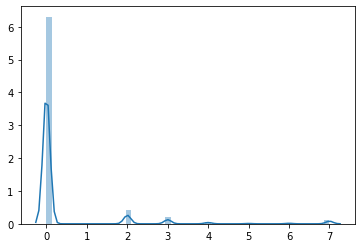

In [46]:
z = y.idxmax(axis=1)
sns.distplot(z),z.value_counts()

In [47]:
#提出用のファイル
x = pd.DataFrame(range(len(pred_xgb)))
submission = pd.concat([x, y], axis=1)

submission.columns = [0,1,2,3,4,5,6,7,8]
#submission.to_csv('submit9.csv', header=False, index=False)

In [48]:
#特徴量の重要度の可視化

feature_importance_xgb = xgb.feature_importances_
importance_xgb = pd.DataFrame({'features':test_x.columns,'importance':feature_importance_xgb})


In [49]:
importance_xgb

,features,importance
0,試合内投球数,0.011822
1,日付,0.001663
2,時刻,0.000145
3,ホームチームID,0.002368
4,アウェイチームID,0.000352
5,球場ID,0.000000
6,試合種別詳細,0.000000
7,イニング,0.007643
8,表裏,0.000243
9,イニング内打席数,0.010717


In [413]:
# #model->randomforest
# from sklearn.ensemble import RandomForestClassifier
# rf= RandomForestClassifier(max_depth=30,n_estimators=30,random_state=71)
# rf.fit(train_x,train_y)

In [55]:
#テストデータの予測値を確立で出力する。
# pred_rf = rf.predict_proba(test_x)

In [56]:
# pd.DataFrame(pred_rf).head()

In [57]:
# #特徴量の重要度の可視化
# feature_importance_rf = rf.feature_importances_
# importance_rf = pd.DataFrame({'features':test_x.columns,'importance':feature_importance_rf})

In [58]:
# importance_rf

## 評価

In [59]:
train_val.head()

,データ内連番,球種,投球位置区域,年度,試合ID,試合内連番,試合内投球数,日付,時刻,ホームチームID,アウェイチームID,球場ID,球場名,試合種別詳細,イニング,表裏,イニング内打席数,打席内投球数,投手ID,投手チームID,投手投球左右,投手役割,投手登板順,投手試合内対戦打者数,投手試合内投球数,投手イニング内投球数,打者ID,打者チームID,打者打席左右,打者打順,打者守備位置,打者試合内打席数,プレイ前ホームチーム得点数,プレイ前アウェイチーム得点数,プレイ前アウト数,プレイ前ボール数,プレイ前ストライク数,プレイ前走者状況,一塁走者ID,二塁走者ID,三塁走者ID,捕手ID,一塁手ID,二塁手ID,三塁手ID,遊撃手ID,左翼手ID,中堅手ID,右翼手ID,成績対象投手ID,成績対象打者ID,選手ID,チームID,チーム名,選手名,育成選手F,背番号,位置,投,打,身長,体重,生年月日,出身高校ID,出身高校名,出身大学ID,出身大学名,社会人,ドラフト年,ドラフト種別,ドラフト順位,年俸,出身国,出身地,血液型,age,投打EXOR
0,0,0,0,2017,2017033101,1,1,20170331,1,1,4,1,東京ドーム,1,1,0,1,1,1500001,1,0,0,1,1,1,1,900410,4,1,1,中,1,0,0,0,0,0,0,0,0,0,1300027,12049,800002,1200136,700003,1400101,900093,900397,1500001,900410,1502018,1,巨人,マイコラス,0,39,投手,0,0,196,100,19880823,0,不明,0,0,0,NaN,0,NaN,24000,0,不明,不明,28,1
1,1,0,8,2017,2017033101,2,2,20170331,1,1,4,1,東京ドーム,1,1,0,1,2,1500001,1,0,0,1,1,2,2,900410,4,1,1,中,1,0,0,0,0,1,0,0,0,0,1300027,12049,800002,1200136,700003,1400101,900093,900397,1500001,900410,1502018,1,巨人,マイコラス,0,39,投手,0,0,196,100,19880823,0,不明,0,0,0,NaN,0,NaN,24000,0,不明,不明,28,1
2,2,0,5,2017,2017033101,3,3,20170331,1,1,4,1,東京ドーム,1,1,0,1,3,1500001,1,0,0,1,1,3,3,900410,4,1,1,中,1,0,0,0,0,2,0,0,0,0,1300027,12049,800002,1200136,700003,1400101,900093,900397,1500001,900410,1502018,1,巨人,マイコラス,0,39,投手,0,0,196,100,19880823,0,不明,0,0,0,NaN,0,NaN,24000,0,不明,不明,28,1
3,3,0,12,2017,2017033101,4,4,20170331,1,1,4,1,東京ドーム,1,1,0,2,1,1500001,1,0,0,1,2,4,4,11436,4,0,2,二,1,0,0,1,0,0,0,0,0,0,1300027,12049,800002,1200136,700003,1400101,900093,900397,1500001,11436,1502018,1,巨人,マイコラス,0,39,投手,0,0,196,100,19880823,0,不明,0,0,0,NaN,0,NaN,24000,0,不明,不明,28,0
4,4,0,8,2017,2017033101,5,5,20170331,1,1,4,1,東京ドーム,1,1,0,2,2,1500001,1,0,0,1,2,5,5,11436,4,0,2,二,1,0,0,1,0,1,0,0,0,0,1300027,12049,800002,1200136,700003,1400101,900093,900397,1500001,11436,1502018,1,巨人,マイコラス,0,39,投手,0,0,196,100,19880823,0,不明,0,0,0,NaN,0,NaN,24000,0,不明,不明,28,0


In [358]:
#評価(xgb)->クロスバリデーションをしたい
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

tr_x, va_x, tr_y, va_y = train_test_split(train_val_x, train_val_y,
                                                                         test_size=0.2,random_state=71, shuffle=False)

# pitching_rate_yaer_val = get_pitching_rate(get_longf(train_val[:int(len(train_val)*0.8)]))
pitching_rate_team_val = get_pitching_rate_team(get_lf(train_val[:int(len(train_val)*0.8)]))

# columns = ['投手ID','fast_y','curve_y','slider_y','shoot_y','fork_y','change_y','sinker_y','cut_y']
# pitching_rate_yaer_val = pd.DataFrame(pitching_rate_yaer_val,columns=columns)
columns = ['投手ID','対戦チーム','fast_t','curve_t','slider_t','shoot_t','fork_t','change_t','sinker_t','cut_t']
pitching_rate_team_val = pd.DataFrame(pitching_rate_team_val,columns=columns)
pitching_rate_team_val.drop(['対戦チーム'])
# merged_rate_val = pitching_rate_team_val.merge(pitching_rate_yaer_val, on='投手ID', how='left')

tr_x = tr_x.merge(pitching_rate_team_val, on='投手ID', how='left')
va_x = va_x.merge(pitching_rate_team_val, on='投手ID', how='left')

xgb.fit(tr_x,tr_y)
tr_pred_xgb = xgb.predict_proba(tr_x)
va_pred_xgb = xgb.predict_proba(va_x)
loss_tr_xgb = log_loss(tr_y,tr_pred_xgb)
loss_va_xgb = log_loss(va_y,va_pred_xgb)

/Users/tokunagaoozora/.pyenv/versions/3.7.6/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


KeyboardInterrupt: 

In [ ]:
loss_tr_xgb,loss_va_xgb

In [62]:
# #評価(rf)
# from sklearn.metrics import log_loss
# from sklearn.model_selection import train_test_split

# tr_x, va_x, tr_y, va_y = train_test_split(train_x, train_y,
#                                                                          test_size=0.25,random_state=71, shuffle=False)

# rf.fit(tr_x,tr_y)
# tr_pred_rf = rf.predict_proba(tr_x)
# va_pred_rf = rf.predict_proba(va_x)
# loss_tr_rf = log_loss(tr_y,tr_pred_rf)
# loss_va_rf = log_loss(va_y,va_pred_rf)

In [63]:
# loss_tr_rf,loss_va_rf

In [ ]:
#捕手のやつは下がった。
# def get_longf_c(df):
#     df['番号'] =  range(len(df))
#     catcher_info_l = df.loc[:,['日付','捕手ID','球種','番号']]
#     catcher_info_l.index = catcher_info_l['日付']
#     catcher_info_l = catcher_info_l.drop(['日付'],axis=1)
#     return catcher_info_l

# #ロングフォーマットをワイドフォーマットにして投球割合を得る。->for文を使わずに書きたいなぁ。
# def get_catching_rate(lf):
#     catcher_info_w = lf.pivot_table(index ='日付' ,columns=('捕手ID','番号'), values = '球種').dropna(how='all')
#     catch_rate = []
#     for i in lf['捕手ID'].unique():
#         df = catcher_info_w[i]
#         df = df.applymap(nan)#数値(True) or NAN(False)
#         x = df.values.sum()#Trueが全投球数なので集計
#         rate=[]
#         rate.append(i)
#         for j in range(8):
#             df2 = catcher_info_w[i] == j#0~7までの球種それぞれをTrueに
#             y = df2.values.sum()#Trueがそれぞれの球種を投げた回数集計
#             rate.append(y/x)#全投球数で割ったものを入れる。
#         catch_rate.append(rate)
#     catch_rate = pd.DataFrame(catch_rate)
#     catch_rate['捕手ID'] = catch_rate[0]
#     catch_rate = catch_rate.drop([0],axis=1)
#     return catch_rate

# catching_rate = get_catching_rate(get_longf_c(tr))

In [1]:
import sys
sys.version

'3.7.6 (default, Feb 10 2020, 19:54:10) \n[Clang 11.0.0 (clang-1100.0.33.17)]'